<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2022-1/Classifica%C3%A7%C3%A3o_Regress%C3%A3o_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pacotes Python: NumPy, Pandas, matplotlib, scikit-learn, ...

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(
    {'font.size': 18,
     'font.family': 'sans-serif',
     'legend.fontsize': 14,
     'axes.labelsize': 22,
     'xtick.labelsize': 14,
     'ytick.labelsize': 14
    }
    )
import sklearn

### Criando uma amostra de dados
A amostra de dados tem duas variáveis dependentes ($x_1$ e $x_2$). Os dados são classificados com $y = +1$ ou $y = -1$.

In [2]:
x1_min = 0.
x1_max = 5.
x2_min = 0.
x2_max = 5.

def create_dataset( n_data, p0, p1 ):
    def func_sep( X ):
        return +1 if ( X[1] >= p0 + p1 * X[0] ) else -1

    X = np.c_[
        x1_min + ( x1_max - x1_min ) * np.random.rand( n_data, 1 ),
        x2_min + ( x2_max - x2_min ) * np.random.rand( n_data, 1 )
        ]

    y = np.apply_along_axis( func_sep, 1, X ).astype( np.int32 )

    return ( X, y )

In [3]:
np.random.seed( 42 )
n_data = 50
p0 = 3.0
p1 = -0.5
X_train, y_train = create_dataset( n_data, p0, p1 )

In [4]:
df_train = pd.DataFrame( np.c_[ X_train, y_train ], columns=( "x1", "x2", "y_label" ) ).astype( { "y_label": "int32" } )
df_train

,x1,x2,y_label
0,1.872701,4.847923,1
1,4.753572,3.875664,1
2,3.659970,4.697495,1
3,2.993292,4.474137,1
4,0.780093,2.989500,1
5,0.779973,4.609371,1
6,0.290418,0.442463,-1
7,4.330881,0.979914,1
8,3.005575,0.226136,-1
9,3.540363,1.626652,1


[]

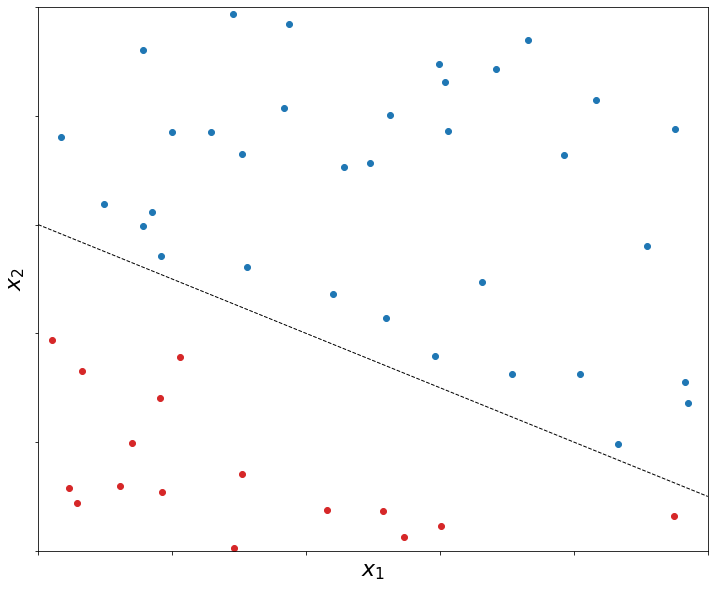

In [5]:
fig = plt.figure( figsize=(12,10) )

msk_sig = ( df_train[ "y_label" ] == +1 )
msk_bkg = ( df_train[ "y_label" ] == -1 )
df_train_sig = df_train[ msk_sig ]
df_train_bkg = df_train[ msk_bkg ]
plt.plot( df_train_sig[ "x1" ], df_train_sig[ "x2" ], 'o', color='tab:blue' )
plt.plot( df_train_bkg[ "x1" ], df_train_bkg[ "x2" ], 'o', color='tab:red' )
plt.plot( [ x1_min, x1_max ], [ ( p0 + p1 * x1_min ), ( p0 + p1 * x1_max ) ], linestyle='dashed', linewidth=1, color='black' )

plt.xlim( x1_min, x1_max )
plt.ylim( x2_min, x2_max )
plt.xlabel( r'$x_1$' )
plt.ylabel( r'$x_2$' )
plt.gca().xaxis.set_ticklabels( [] )
plt.gca().yaxis.set_ticklabels( [] )

### Determinação dos parâmetros do modelo (treinamento)

Minimização:

$S^{ \textrm{min} }_{ \mathbf{w} } = \min_{ \mathbf{w} } \frac{1}{N} \sum_{n=1}^{N} \left( \mathbf{w}^{T} \cdot \mathbf{x}_n - y_n \right)^2$

$\mathbf{x}_n = \begin{pmatrix} 1 \\ x_{1, n} \\ x_{2,n} \end{pmatrix} , \quad \mathbf{w} = \begin{pmatrix} w_0 \\ w_1 \\ w_2 \end{pmatrix}$

$S^{ \textrm{min} }_{ \mathbf{w} } = \min_{ \mathbf{w} } \frac{1}{N} { \lvert\lvert \mathbf{X} \cdot \mathbf{w} - \mathbf{y} \rvert\rvert_{\ell^2} }^2$

$\mathbf{X} = \begin{pmatrix} 1 & x_{1,1} & x_{2,1} \\ 1 & x_{1,2} & x_{2,2} \\ ... \\ 1 & x_{1,N} & x_{2,N} \end{pmatrix} , \quad \mathbf{y} = \begin{pmatrix} y_1 \\ y_2 \\ ... \\ y_N \end{pmatrix}$

$\mathbf{w} = \left( \mathbf{X}^{T} \mathbf{X} \right)^{-1} \mathbf{X}^{T} \mathbf{y} $

In [6]:
from sklearn import linear_model
linear_reg = linear_model.LinearRegression()
linear_reg.fit( df_train[ [ "x1", "x2" ] ], df_train[ "y_label" ] )
print ( linear_reg.coef_ )
print ( linear_reg.intercept_ )

[0.21043994 0.46401667]
-1.2563373930328878


### Predições de acordo com o modelo ajustado

Classificação (predição) para um dado $\mathbf{x}$, de acordo com o modelo ajustado (vetor $\mathbf{w}$):

$h( \mathbf{x}; \mathbf{w} ) = \textrm{sign}( \mathbf{w}^{T} \cdot \mathbf{x} )$

In [7]:
df_train[ "y_predict" ] = pd.Series( ( linear_reg.predict( df_train[ [ "x1", "x2" ] ] ) >= 0. ) ).map( { True: +1, False: -1} )
df_train

,x1,x2,y_label,y_predict
0,1.872701,4.847923,1,1
1,4.753572,3.875664,1,1
2,3.659970,4.697495,1,1
3,2.993292,4.474137,1,1
4,0.780093,2.989500,1,1
5,0.779973,4.609371,1,1
6,0.290418,0.442463,-1,-1
7,4.330881,0.979914,1,1
8,3.005575,0.226136,-1,-1
9,3.540363,1.626652,1,1


### Cálculo do erro de classificação

$E( \mathbf{w} ) = \frac{1}{N} \sum_{n=1}^{N} \epsilon_n( \mathbf{x}_n; \mathbf{w} )$

$\epsilon_n( \mathbf{x}_n; \mathbf{w} ) = \begin{cases} 0 , \quad h( \mathbf{x}_n; \mathbf{w} ) = y_n \\ 1 , \quad h( \mathbf{x}_n; \mathbf{w} ) \neq y_n \end{cases}$

In [8]:
error_train = np.sum( df_train[ "y_label" ] != df_train[ "y_predict" ] ) / df_train.shape[0]
print ( error_train )

0.0


### Contorno de classificação do modelo

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


[]

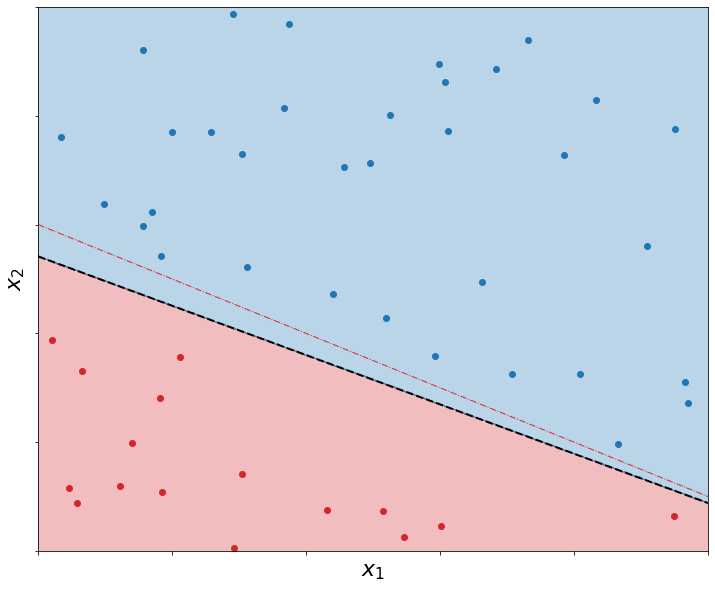

In [9]:
fig = plt.figure( figsize=(12,10) )

n_points_ = 500
data_x1_ = np.linspace( x1_min, x1_max, n_points_ )[ : , np.newaxis ]
data_x2_ = np.linspace( x1_min, x1_max, n_points_ )[ : , np.newaxis ]
grid_x1_, grid_x2_ = np.meshgrid( data_x1_, data_x2_ )
datascan_ = np.c_[ grid_x1_.ravel(), grid_x2_.ravel() ]
datascan_predict_ = ( linear_reg.predict( datascan_ ).reshape( grid_x1_.shape ) >= 0. )

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap( ['tab:red','tab:blue'] )
plt.contourf( grid_x1_, grid_x2_, datascan_predict_, cmap=custom_cmap, alpha=0.30 )

msk_sig = ( df_train[ "y_predict" ] == +1 )
msk_bkg = ( df_train[ "y_predict" ] == -1 )
df_train_sig = df_train[ msk_sig ]
df_train_bkg = df_train[ msk_bkg ]
plt.plot( df_train_sig[ "x1" ], df_train_sig[ "x2" ], 'o', color='tab:blue' )
plt.plot( df_train_bkg[ "x1" ], df_train_bkg[ "x2" ], 'o', color='tab:red' )
f_ = lambda x_: -( linear_reg.intercept_ + linear_reg.coef_[0] * x_) / linear_reg.coef_[1]
plt.plot( [ x1_min, x1_max ], [ ( p0 + p1 * x1_min ), ( p0 + p1 * x1_max ) ], linestyle='dashdot', linewidth=1, color='tab:red' )
plt.plot( [ x1_min, x1_max ], [ f_( x1_min ), f_( x1_max ) ], linestyle='dashed', linewidth=2, color='black' )

plt.xlim( x1_min, x1_max )
plt.ylim( x2_min, x2_max )
plt.xlabel( r'$x_1$' )
plt.ylabel( r'$x_2$' )
plt.gca().xaxis.set_ticklabels( [] )
plt.gca().yaxis.set_ticklabels( [] )

### Amostra de teste
O modelo foi otimizado sem olhar para os dados de teste. Os dados de teste são previamente classificados como a amostra de treinamento, com $y = +1$ ou $y = -1$.

A performance do modelo na amostra de teste serve como estimativa da performance em dados novos.

In [10]:
np.random.seed( 100 )

X_test, y_test = create_dataset( n_data, p0, p1 )
df_test = pd.DataFrame( np.c_[ X_test, y_test ], columns=( "x1", "x2", "y_label" ) ).astype( { "y_label": "int32" } )

[]

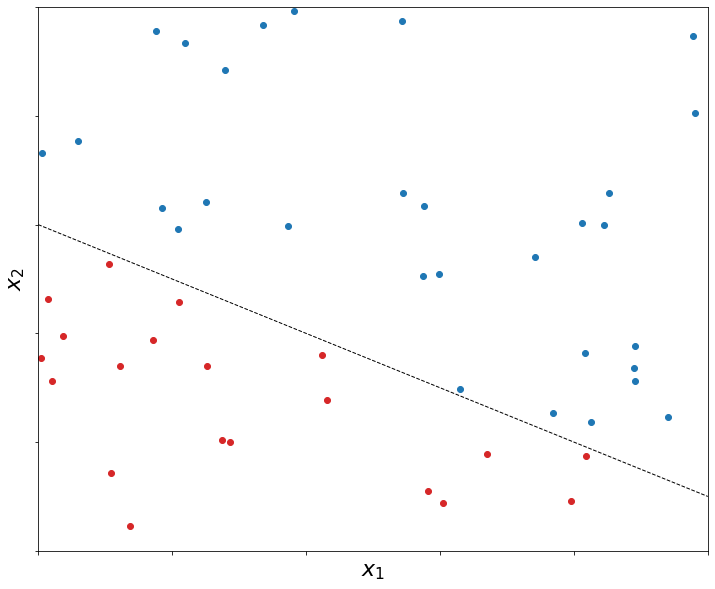

In [11]:
fig = plt.figure( figsize=(12,10) )

msk_sig = ( df_test[ "y_label" ] == +1 )
msk_bkg = ( df_test[ "y_label" ] == -1 )
df_test_sig = df_test[ msk_sig ]
df_test_bkg = df_test[ msk_bkg ]
plt.plot( df_test_sig[ "x1" ], df_test_sig[ "x2" ], 'o', color='tab:blue' )
plt.plot( df_test_bkg[ "x1" ], df_test_bkg[ "x2" ], 'o', color='tab:red' )
plt.plot( [ x1_min, x1_max ], [ ( p0 + p1 * x1_min ), ( p0 + p1 * x1_max ) ], linestyle='dashed', linewidth=1, color='black' )

plt.xlim( x1_min, x1_max )
plt.ylim( x2_min, x2_max )
plt.xlabel( r'$x_1$' )
plt.ylabel( r'$x_2$' )
plt.gca().xaxis.set_ticklabels( [] )
plt.gca().yaxis.set_ticklabels( [] )

### Predição para a amostra de teste usando o modelo ajustado com a amostra de treinamento.

$h( \mathbf{x}; \mathbf{w} ) = \textrm{sign}( \mathbf{w}^{T} \cdot \mathbf{x} )$

$E( \mathbf{w} ) = \frac{1}{N} \sum_{n=1}^{N} \epsilon_n( \mathbf{x}_n; \mathbf{w} )$

$\epsilon_n( \mathbf{x}_n; \mathbf{w} ) = \begin{cases} 0 , \quad h( \mathbf{x}_n; \mathbf{w} ) = y_n \\ 1 , \quad h( \mathbf{x}_n; \mathbf{w} ) \neq y_n \end{cases}$

In [12]:
df_test[ "y_predict" ] = pd.Series( ( linear_reg.predict( df_test[ [ "x1", "x2" ] ] ) >= 0. ) ).map( { True: +1, False: -1} )
error_test = np.sum( df_test[ "y_label" ] != df_test[ "y_predict" ] ) / df_test.shape[0]
print ( error_test )

0.08


**Os pontos laranjas são classificados incorretamente:** $h( \mathbf{x}_n; \mathbf{w} ) \neq y_n$

[]

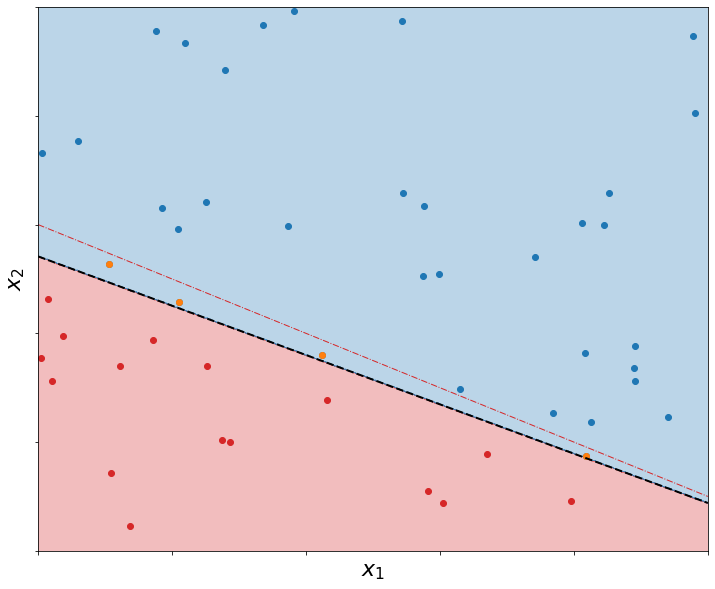

In [13]:
fig = plt.figure( figsize=(12,10) )

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap( ['tab:red','tab:blue'] )
plt.contourf( grid_x1_, grid_x2_, datascan_predict_, cmap=custom_cmap, alpha=0.30 )

msk_sig = ( df_test[ "y_predict" ] == +1 )
msk_bkg = ( df_test[ "y_predict" ] == -1 )
msk_error = ( df_test[ "y_label" ] != df_test[ "y_predict" ] )
df_test_sig = df_test[ msk_sig ]
df_test_bkg = df_test[ msk_bkg ]
df_test_error = df_test[ msk_error ]
plt.plot( df_test_sig[ "x1" ], df_test_sig[ "x2" ], 'o', color='tab:blue' )
plt.plot( df_test_bkg[ "x1" ], df_test_bkg[ "x2" ], 'o', color='tab:red' )
plt.plot( df_test_error[ "x1" ], df_test_error[ "x2" ], 'o', color='tab:orange' )
plt.plot( [ x1_min, x1_max ], [ ( p0 + p1 * x1_min ), ( p0 + p1 * x1_max ) ], linestyle='dashdot', linewidth=1, color='tab:red' )
plt.plot( [ x1_min, x1_max ], [ f_( x1_min ), f_( x1_max ) ], linestyle='dashed', linewidth=2, color='black' )

plt.xlim( x1_min, x1_max )
plt.ylim( x2_min, x2_max )
plt.xlabel( r'$x_1$' )
plt.ylabel( r'$x_2$' )
plt.gca().xaxis.set_ticklabels( [] )
plt.gca().yaxis.set_ticklabels( [] )